In [1]:
from pathlib import Path
from typing import Optional, Sequence

import xarray as xr
import numpy as np

from preprocessing_utils import (
    rho,
    AREAS,
    subset_S,
    subset_U,
    subset_S75pc,
    time_window,
    pipeline,
    mean_response_in_window,
    pipeline_all_correct_order,
    pipeline_all
)

import pandas as pd

In [2]:
zar_dir = Path("../AllenData/neuropixels.zarr/")
ds = xr.open_zarr(zar_dir, consolidated=True)
ds

<xarray.Dataset> Size: 10GB
Dimensions:                          (trials: 50, frame_id: 118,
                                      time_relative_to_stimulus_onset: 25,
                                      units: 8301, dim_0: 118, dim_1: 918,
                                      dim_2: 1174)
Coordinates:
  * frame_id                         (frame_id) int64 944B 0 1 2 ... 115 116 117
    image_selectivity_ns             (units) float64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    run_pval_ns                      (units) float64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    specimen_id                      (units) int64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    splithalf_r_mean                 (time_relative_to_stimulus_onset, units) float64 2MB dask.array<chunksize=(13, 4151), meta=np.ndarray>
    splithalf_r_std                  (time_relative_to_stimulus_onset, units) float64 2MB dask.array<chunksize=(13, 4151), meta=np.ndarray>
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 200B ...
  * trials                           (trials) int64 400B 1 2 3 4 ... 47 48 49 50
    unit_id                          (units) int64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    visual_area                      (units) object 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
Dimensions without coordinates: units, dim_0, dim_1, dim_2
Data variables:
    neural_data                      (trials, frame_id, time_relative_to_stimulus_onset, units) float64 10GB dask.array<chunksize=(7, 15, 4, 1038), meta=np.ndarray>
    stimuli                          (dim_0, dim_1, dim_2) uint8 127MB dask.array<chunksize=(15, 230, 294), meta=np.ndarray>

# Esplorazione

Calcolo la split half consistency di ogni unità per ogni time bin. Esiste già tabulata in `ds`, creo una utility per accedere comodamente: $\rho_u(b)$

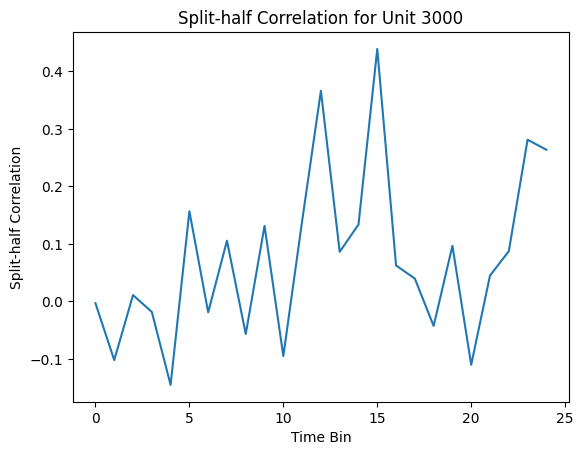

In [3]:
import matplotlib.pyplot as plt

plt.plot(rho(ds, 3002))
plt.xlabel("Time Bin")
plt.ylabel("Split-half Correlation")
plt.title("Split-half Correlation for Unit 3000")
plt.show()

A parità di area, le unità sono tutte diverse tra topi diversi?

Ogni unità ha un id preciso, ed ogni id corrisponde ad un solo neurone per un particolare topo, dunque sono tutti unici.

In [26]:
# area = "VISrl"

for area in AREAS:
    specimens = subset_S(ds, area)

    total_units = 0
    unique_units = set()
    for s in specimens:
        # print(f"Specimen ID: {s}")
        units_in_s = subset_U(ds, s, area)
        # print(f"Units in {area}: {units_in_s}")
        total_units += len(units_in_s)
        unique_units.update(units_in_s)
        # print()

    print(f"Total number of units in {area} across all specimens: {total_units}")
    print(f"Number of unique units in {area} across all specimens: {len(unique_units)}")

Total number of units in VISp across all specimens: 2015
Number of unique units in VISp across all specimens: 2015
Total number of units in VISl across all specimens: 933
Number of unique units in VISl across all specimens: 933
Total number of units in VISal across all specimens: 1553
Number of unique units in VISal across all specimens: 1553
Total number of units in VISpm across all specimens: 879
Number of unique units in VISpm across all specimens: 879
Total number of units in VISrl across all specimens: 1415
Number of unique units in VISrl across all specimens: 1415
Total number of units in VISam across all specimens: 1506
Number of unique units in VISam across all specimens: 1506


Sia un'area $a\in A$ e un certo topo $s\in S(a)$. Fisso una certa unità $u\in U(s,a)$ e per ogni coppia immagine $i\in I$ e trial $t\in T$ colcolo la risposta media nel tempo (sui time bin).

In [77]:
# prendo un topo s in VISp
area = "VISp"

s = subset_S(ds, area)[0]
print(f"Specimen ID: {s}")
units_in_s = subset_U(ds, s, area)
print(f"Units in {area}: {units_in_s}")

Specimen ID: 699733581
Units in VISp: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [73]:
# calcolo la time window per questo topo e area in cui le risposte sono più consistenti (consistenza media su half-split >= 0.3)

start, end = time_window(ds, s, area)

print(f"Time window for specimen {s} in area {area}: {start} to {end}")

Time window for specimen 699733581 in area VISp: 12 to 17


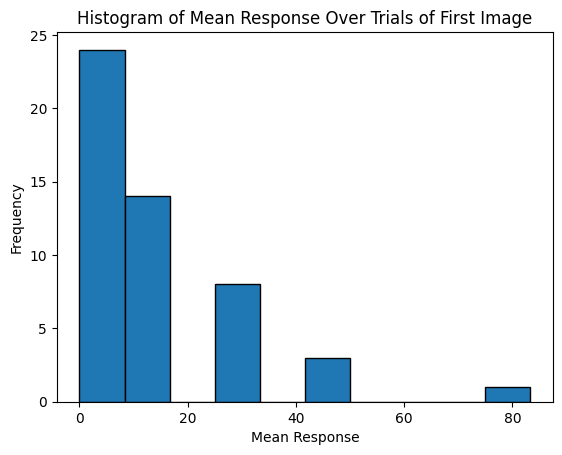

In [74]:
# calcolo la risposta media di una unità in questa finestra temporale per ogni immagine e trial

mean_response = mean_response_in_window(ds, units_in_s[0], start, end)

# plot the histogram of the mean response for the first 5 trials of the first image
plt.hist(mean_response[:50,0].T.flatten(), bins=10, edgecolor='black')
plt.xlabel("Mean Response")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Response Over Trials of First Image")
plt.show()

# Preprocessing 

## Pipeline per un topo (per un'area fissata)
La funzione `pipeline` automatizza la precedente procedura, su tutte le unità di una certa area in un certo topo. Restituisce un array 3D di shape (num_units, num_trials, num_images) con le risposte medie nel tempo (sulla finestra definita per quella coppia topo-area) per ogni unità, immagine e trial.

In [ ]:
area = "VISp"

s = subset_S(ds, area)[0]

all_responses_s = pipeline(ds, s, area)
print(f"Shape of all responses for specimen {s} in area {area}: {all_responses_s.shape}")

Shape of all responses for specimen 699733581 in area VISp: (60, 50, 118)


## Pipeline su tutti i topi (per un'area fissata)

Secondo la procedura di Nayebi:

1. selezionare solo quelle unità neurali la cui attività massima, evocata dall’immagine a cui sono più sensibili, non dipende dalla velocità con cui il topo corre (run_pval_ns > 0.05)

In [5]:
ds_filtered = ds.where((ds.run_pval_ns > 0.05).compute(), drop=True)
ds_filtered

<xarray.Dataset> Size: 2TB
Dimensions:                          (trials: 50, frame_id: 118,
                                      time_relative_to_stimulus_onset: 25,
                                      units: 4007, dim_0: 118, dim_1: 918,
                                      dim_2: 1174)
Coordinates:
  * frame_id                         (frame_id) int64 944B 0 1 2 ... 115 116 117
    image_selectivity_ns             (units) float64 32kB 0.3579 ... 0.6957
    run_pval_ns                      (units) float64 32kB 0.2234 ... 0.6721
    specimen_id                      (units) int64 32kB 699733581 ... 772616823
    splithalf_r_mean                 (time_relative_to_stimulus_onset, units) float64 801kB dask.array<chunksize=(13, 4007), meta=np.ndarray>
    splithalf_r_std                  (time_relative_to_stimulus_onset, units) float64 801kB dask.array<chunksize=(13, 4007), meta=np.ndarray>
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 200B ...
  * trials                           (trials) int64 400B 1 2 3 4 ... 47 48 49 50
    unit_id                          (units) int64 32kB 950930276 ... 951088476
    visual_area                      (units) object 32kB 'VISp' ... 'VISam'
Dimensions without coordinates: units, dim_0, dim_1, dim_2
Data variables:
    neural_data                      (trials, frame_id, time_relative_to_stimulus_onset, units) float64 5GB dask.array<chunksize=(7, 15, 4, 1037), meta=np.ndarray>
    stimuli                          (dim_0, dim_1, dim_2, units) float32 2TB dask.array<chunksize=(15, 230, 294, 4007), meta=np.ndarray>

In [6]:
# prendo un topo s in VISp
area = "VISp"

s = subset_S(ds_filtered, area)[0]
print(f"Specimen ID: {s}")
units_in_s = subset_U(ds_filtered, s, area)
print(f"Units in {area}: {units_in_s}")

Specimen ID: 699733581
Units in VISp: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


2. applicare la precedente pipeline per ogni topo in quell'area
3. calcolare il numero di unità risultanti per ogni topo, e selezionare solo quei topi che hanno almeno il 75° percentile di unità (per assicurarsi che non ci siano topi con pochissime unità)

questi due step vengono fatti nella funzione `pipeline_all_correct_order`. Secondo la procedura di Nayebi, il filtro sul p-value va fatto prima di tutto, poi la pipeline su ogni topo, e infine il filtro sui topi con poche unità.

In [7]:
all_responses_v1 = pipeline_all_correct_order(ds_filtered, "VISp", threshold=0.3)
if all_responses_v1 is not None:
    print(f"Shape of all responses in VISp after filtering: {all_responses_v1.shape}")

Processing specimen 699733581 in area VISp
Processing specimen 703279284 in area VISp
Processing specimen 707296982 in area VISp
Processing specimen 716813543 in area VISp
Processing specimen 717038288 in area VISp
Processing specimen 718643567 in area VISp
Processing specimen 719817805 in area VISp
Processing specimen 719828690 in area VISp
Processing specimen 722882755 in area VISp
Processing specimen 723627604 in area VISp
Processing specimen 726141251 in area VISp
Processing specimen 726162197 in area VISp
Processing specimen 726170935 in area VISp
Processing specimen 726298253 in area VISp
Processing specimen 730756780 in area VISp
Processing specimen 730760270 in area VISp
Processing specimen 732548380 in area VISp
Processing specimen 733457989 in area VISp
Processing specimen 734865738 in area VISp
Processing specimen 735109609 in area VISp
Processing specimen 738651054 in area VISp
Processing specimen 739783171 in area VISp
Processing specimen 740268986 in area VISp
Processing 